# Isoline average
In many applications, it is interesting to see how a metric evolves with the distance to the surface of the an object. This tutorial shows a such example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.filters as flt
from scipy.ndimage import distance_transform_edt as edt
import astropy.io.fits as fits
import tifffile as tiff

## Load and inspect an image

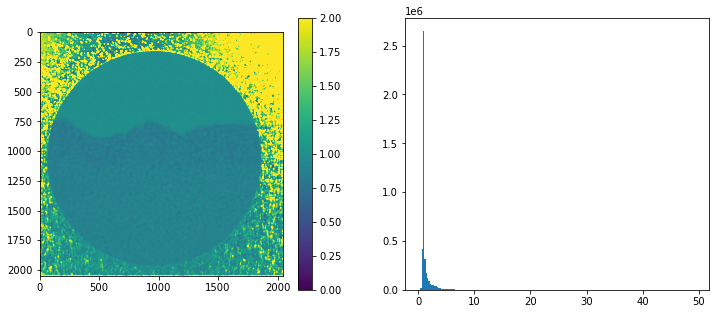

In [3]:
img = tiff.imread('data/Accusand_50_70_lowsuction_0_6_hours_0.tif')[::-1]

fig, ax = plt.subplots(1,2,figsize=(12,5))
a=ax[0].imshow(img,vmin=0,vmax=2)
fig.colorbar(a,ax=ax[0])
ax[1].hist(img.ravel(),bins=200);

In this example we wnat to measure the gray level distribution as function of the distance from the soil surface.
The task involves two main operations:
1. Compute the distance map 
2. Compute the average and standard deviation of the image intensity at distances given by the distance map (i.e. the isolines).
    
We can identify two problems here:
- The FOV is circular
- There are great variations in intensity.

## Prepare the mask for the distance map
The first thing we do is to create a mask to separate the relevant data from the background and set the background to zero. The histogram of the masked area shows two clear peaks and a threshold can be found by locating the minimum between the two peaks. Otsu threshold would also work but produces larger holes in the soil due to textural variations. 

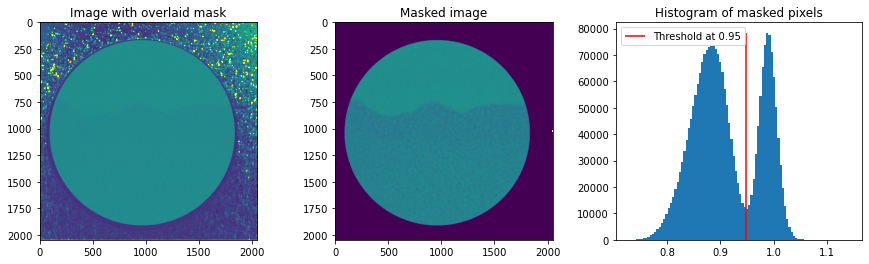

In [95]:
u=np.arange(img.shape[0])
x,y=np.meshgrid(u,u)
x0=960
y0=1040
R=870
mask = np.sqrt((x-x0)**2+(y-y0)**2)<R
fig,ax=plt.subplots(1,3,figsize=(15,4))
ax[0].imshow(mask*2+img,vmin=0,vmax=6)
ax[0].set_title('Image with overlaid mask')
ax[1].imshow(mask*img,vmin=0,vmax=2)
ax[1].set_title('Masked image')
h=ax[2].hist(img[mask],bins=100);

th=flt.threshold_minimum(img[mask])
ax[2].vlines([th],ymin=0,ymax=h[0].max(),color='red',label='Threshold at {0:0.2f}'.format(th));
ax[2].set_title('Histogram of masked pixels')
ax[2].legend();

### Apply threshold and clean up misclassified pixels
We now apply the threshold and set pixels below it to one. This produces mask image that has all pixels not belonging to the air set to one, including the area out side the active field of view. The misclassified pixels are removed using a sequence of morphological closing and opening.

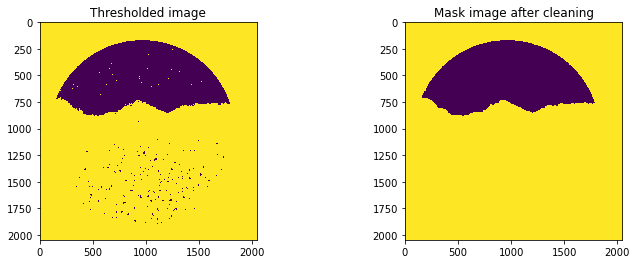

In [97]:
bi=img*mask<th
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(bi,interpolation='none')
ax[0].set_title('Thresholded image')
bioc=morph.opening(morph.closing(bi,morph.disk(10)),morph.disk(7))
ax[1].imshow(bioc,interpolation='none');
ax[1].set_title('Mask image after cleaning');

If we compute the distance using this mask, you will see that it will bias the measurements!

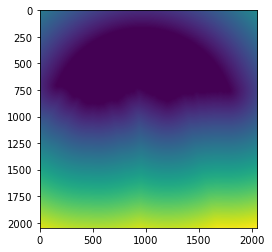

In [99]:
plt.imshow(edt(bioc));

The problem is that the distance is also computed for the upper part. This can be handled by cropping the image and set all pixels above a give vertical position to zero.

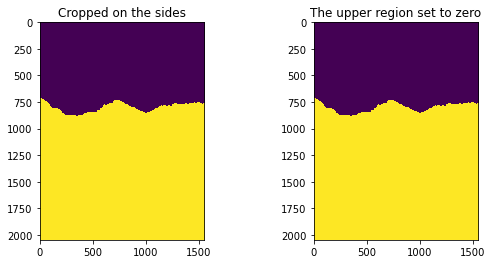

In [102]:
fig,ax=plt.subplots(1,2,figsize=(9,4))
cbioc=bioc[:,200:1750]
ax[0].imshow(cbioc,interpolation='none')
ax[0].set_title('Cropped on the sides')
cbioc[:700]=0
ax[1].imshow(cbioc,interpolation='none')
ax[1].set_title('The upper region set to zero');

### Putting it all together
In this last step we compute the distance map, which now only measures the distance from the surface into the soil. Some additional masking is needed to avoid the data outside the FOV.

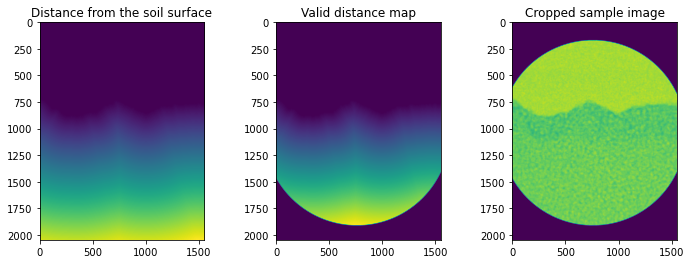

In [104]:
d = np.around(edt(cbioc),decimals=0)
fig,ax=plt.subplots(1,3,figsize=(12,4))

ax[0].imshow(d)
ax[0].set_title('Distance from the soil surface')
cm=mask[:,200:1750]
md=d*cm
ax[1].imshow(md)
ax[1].set_title('Valid distance map')
cimg=(img*mask)[:,200:1750]
ax[2].imshow(cimg)
ax[2].set_title('Cropped sample image');

## Measure the isoline statistics
To measure the isoline statistics we need to know the distance to look for. This is easiest done using a function that lists the unique values in the image.

In [105]:
dd = np.unique(md) 

Next we loop over all distances and compute the average intensity in the region corresponding to each distance. The distance list is trimmed in the beginning and end to avoid boundary effects.

In [79]:
dd_reduced = dd[2:-10]
p_avg = np.zeros(dd_reduced.shape)
p_std = np.zeros(dd_reduced.shape)
for idx,dist in enumerate(dd_reduced) :
    p_avg[idx]=cimg[md==dist].mean()
    p_std[idx]=cimg[md==dist].std()

Finally, we plot the results with error bands to show the variations.

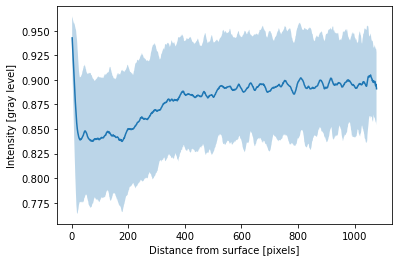

In [85]:
plt.plot(dd_reduced,p_avg)
c=1.96
plt.fill_between(dd_reduced,p_avg-c*p_std,p_avg+c*p_std,alpha=0.3)
plt.xlabel('Distance from surface [pixels]')
plt.ylabel('Intensity [gray level]');